In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install timesformer-pytorch
!pip install timesformer-pytorch


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import torch.optim as optim
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from tqdm import tqdm
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR

from timesformer_pytorch import TimeSformer

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42.")

Random seed set to 42.


In [ ]:
# Path to data
data_dir = '/content/drive/MyDrive/UCF101/UCF-101'

# Verify that the data directory exists
assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
print(f"Data directory: {data_dir}")


Data directory: /content/drive/MyDrive/UCF101/UCF-101


In [ ]:
# Create class mappings
def get_class_to_idx(data_dir):
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}
    return class_to_idx, idx_to_class

class_to_idx, idx_to_class = get_class_to_idx(data_dir)
print(f"Number of classes: {len(class_to_idx)}")
print("First 5 class mappings:")
for cls_name, idx in list(class_to_idx.items())[:5]:
    print(f"{cls_name}: {idx}")

# Collect all videos
def get_all_videos(data_dir, class_to_idx):
    video_list = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for video_name in os.listdir(class_path):
            if video_name.endswith(('.avi', '.mp4', '.mov', '.mkv')):
                video_path = os.path.join(class_name, video_name)
                label = class_to_idx[class_name]
                video_list.append((video_path, label))
    return video_list

all_videos = get_all_videos(data_dir, class_to_idx)
print(f"Total number of videos found: {len(all_videos)}")


Number of classes: 101
First 5 class mappings:
ApplyEyeMakeup: 0
ApplyLipstick: 1
Archery: 2
BabyCrawling: 3
BalanceBeam: 4
Total number of videos found: 13320


In [ ]:
# Split data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_videos, temp_videos = train_test_split(
    all_videos,
    test_size=(1 - train_ratio),
    stratify=[label for _, label in all_videos],
    random_state=42
)

val_videos, test_videos = train_test_split(
    temp_videos,
    test_size=(test_ratio / (test_ratio + val_ratio)),
    stratify=[label for _, label in temp_videos],
    random_state=42
)

print(f"Number of training videos: {len(train_videos)}")
print(f"Number of validation videos: {len(val_videos)}")
print(f"Number of testing videos: {len(test_videos)}")


Number of training videos: 9323
Number of validation videos: 1998
Number of testing videos: 1999


In [ ]:
# Verify video paths
def verify_video_paths(videos, data_dir):
    missing_videos = []
    for video, _ in videos:
        video_path = os.path.join(data_dir, video)
        if not os.path.exists(video_path):
            missing_videos.append(video)
    return missing_videos

# Verify training videos
missing_train = verify_video_paths(train_videos, data_dir)
if missing_train:
    print(f"\nMissing {len(missing_train)} training videos:")
    for video in missing_train:
        print(video)
    # Remove missing videos
    train_videos = [v for v in train_videos if v[0] not in missing_train]
else:
    print("\nAll training videos are present.")


All training videos are present.


In [ ]:
NUM_CLASSES = 101
selected_classes = sorted(class_to_idx.keys())[:NUM_CLASSES]
selected_class_to_idx = {cls_name: idx for idx, cls_name in enumerate(selected_classes)}
selected_idx_to_class = {idx: cls_name for cls_name, idx in selected_class_to_idx.items()}

print(f"Selected {len(selected_class_to_idx)} classes.")
print("Selected class mappings (first 5):")
for cls_name, idx in list(selected_class_to_idx.items())[:5]:
    print(f"{cls_name}: {idx}")

# Filter videos by selected classes
def filter_videos_by_classes(videos, selected_class_to_idx):
    filtered_videos = []
    for video_path, label in videos:
        class_name = video_path.split('/')[0]
        if class_name in selected_class_to_idx:
            new_label = selected_class_to_idx[class_name]
            filtered_videos.append((video_path, new_label))
    return filtered_videos

train_videos_filtered = filter_videos_by_classes(train_videos, selected_class_to_idx)
val_videos_filtered = filter_videos_by_classes(val_videos, selected_class_to_idx)
test_videos_filtered = filter_videos_by_classes(test_videos, selected_class_to_idx)

print(f"Number of training videos after filtering: {len(train_videos_filtered)}")
print(f"Number of validation videos after filtering: {len(val_videos_filtered)}")
print(f"Number of testing videos after filtering: {len(test_videos_filtered)}")


Selected 101 classes.
Selected class mappings (first 5):
ApplyEyeMakeup: 0
ApplyLipstick: 1
Archery: 2
BabyCrawling: 3
BalanceBeam: 4
Number of training videos after filtering: 9323
Number of validation videos after filtering: 1998
Number of testing videos after filtering: 1999


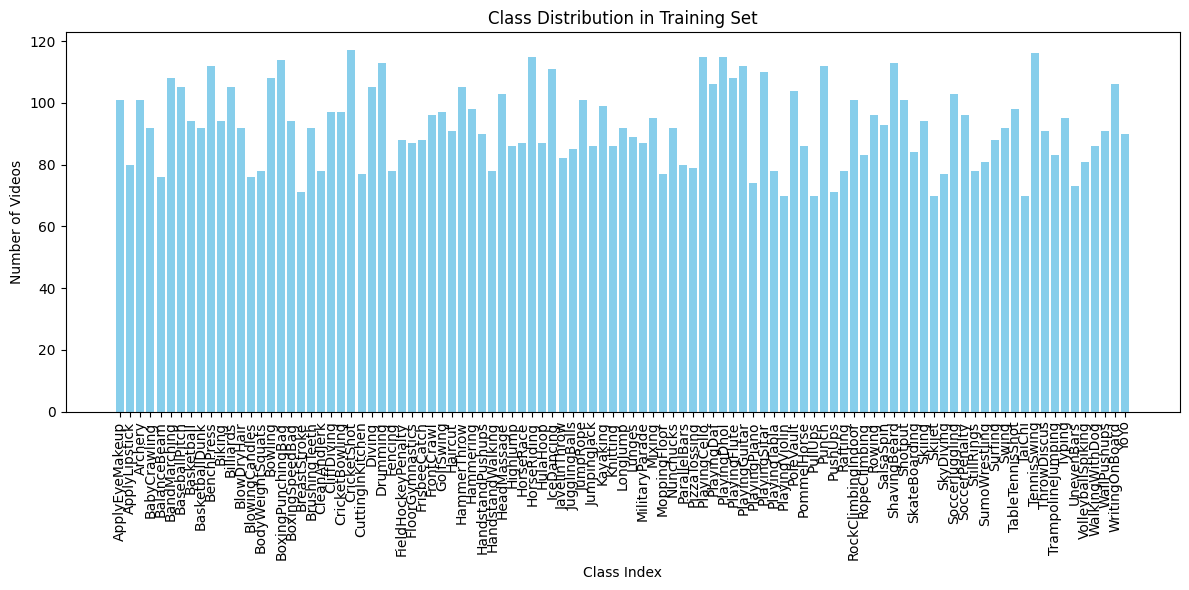

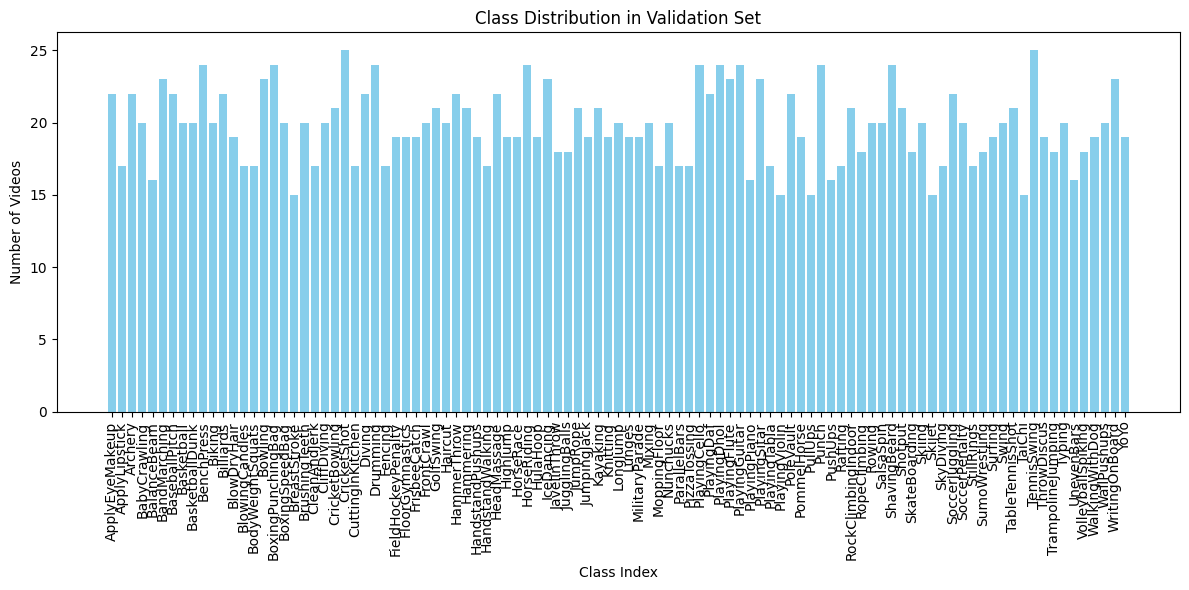

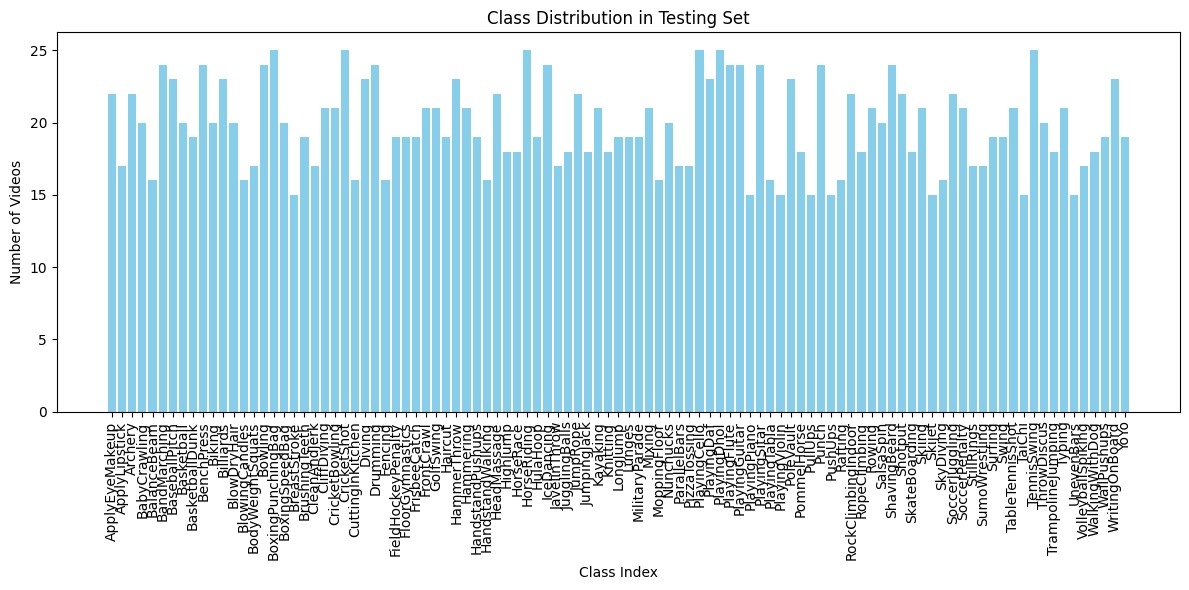

In [ ]:
# Plot class distribution
def plot_class_distribution(videos, split_name):
    labels = [label for _, label in videos]
    counter = Counter(labels)
    classes = sorted(counter.keys())
    counts = [counter[cls] for cls in classes]

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class Index')
    plt.ylabel('Number of Videos')
    plt.title(f'Class Distribution in {split_name} Set')
    plt.xticks(classes, [selected_idx_to_class[cls] for cls in classes], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_class_distribution(train_videos_filtered, 'Training')
plot_class_distribution(val_videos_filtered, 'Validation')
plot_class_distribution(test_videos_filtered, 'Testing')


In [ ]:
class NormalizeVideo:
    """
    Applies normalization to each frame in the video tensor.
    """
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean=mean, std=std)

    def __call__(self, video):
        C, T, H, W = video.shape
        for t in range(T):
            video[:, t, :, :] = self.normalize(video[:, t, :, :])
        return video

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, videos, data_dir, transform=None, num_frames=16, frame_size=(112, 112)):
        """
        Args:
            videos (list): List of tuples [(video_path, label), ...]
            data_dir (str): Directory where videos are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_frames (int): Number of frames to sample from each video.
            frame_size (tuple): Desired frame size (height, width).
        """
        self.videos = videos
        self.data_dir = data_dir
        self.transform = transform
        self.num_frames = num_frames
        self.frame_size = frame_size

    def __len__(self):
        return len(self.videos)

    def _load_video(self, video_path):
        full_path = os.path.join(self.data_dir, video_path)

        frames = []
        cap = cv2.VideoCapture(full_path)
        if not cap.isOpened():
            print(f"Warning: Unable to open video: {full_path}")
            return torch.zeros(3, self.num_frames, *self.frame_size)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                frame = np.zeros((*self.frame_size, 3), dtype=np.uint8)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, self.frame_size)
            frame_tensor = transforms.ToTensor()(frame)  # Convert to [C, H, W]
            frames.append(frame_tensor)
        cap.release()

        video = torch.stack(frames, dim=1)  # Shape: [C, T, H, W]
        return video

    def __getitem__(self, idx):
        video_path, label = self.videos[idx]
        video = self._load_video(video_path)

        if self.transform:
            video = self.transform(video)

        label = torch.tensor(label, dtype=torch.long)  # label must be LongTensor
        return video, label


In [ ]:
NUM_FRAMES = 16
FRAME_SIZE = (112, 112)


train_transforms = transforms.Compose([
    NormalizeVideo(mean=[0.43216, 0.394666, 0.37645],
                   std=[0.22803, 0.22145, 0.216989]),
])

test_transforms = transforms.Compose([
    NormalizeVideo(mean=[0.43216, 0.394666, 0.37645],
                   std=[0.22803, 0.22145, 0.216989]),
])

train_dataset = VideoDataset(
    videos=train_videos_filtered,
    data_dir=data_dir,
    transform=train_transforms,
    num_frames=NUM_FRAMES,
    frame_size=FRAME_SIZE
)

val_dataset = VideoDataset(
    videos=val_videos_filtered,
    data_dir=data_dir,
    transform=test_transforms,
    num_frames=NUM_FRAMES,
    frame_size=FRAME_SIZE
)

test_dataset = VideoDataset(
    videos=test_videos_filtered,
    data_dir=data_dir,
    transform=test_transforms,
    num_frames=NUM_FRAMES,
    frame_size=FRAME_SIZE
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 9323
Validation dataset size: 1998
Testing dataset size: 1999


In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [ ]:
model = TimeSformer(
    dim=512,
    image_size=FRAME_SIZE[0],  # 112
    patch_size=16,
    num_frames=NUM_FRAMES,
    num_classes=NUM_CLASSES,
    depth=6,
    heads=8,
    dim_head=64,
    attn_dropout=0.1,
    ff_dropout=0.1
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model moved to device successfully.")

Model moved to device successfully.


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch_videos, batch_labels in loop:
        batch_videos = batch_videos.permute(0, 2, 1, 3, 4)  # [B, T, C, H, W]
        batch_videos = batch_videos.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(batch_videos)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_videos.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=(predicted == batch_labels).float().mean().item())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_outputs = []

    loop = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch_videos, batch_labels in loop:
            batch_videos = batch_videos.permute(0, 2, 1, 3, 4)  # [B, T, C, H, W]
            batch_videos = batch_videos.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_videos)  # [B, num_classes]
            loss = criterion(outputs, batch_labels)

            running_loss += loss.item() * batch_videos.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            # predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_outputs.extend(F.softmax(outputs, dim=1).cpu().numpy())

            # Update progress bar
            loop.set_postfix(loss=loss.item(), acc=(predicted == batch_labels).float().mean().item())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # F1-score (macro average)
    f1 = f1_score(all_labels, all_preds, average='macro')

    # AUC (One-vs-Rest)
    try:
        auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr')
    except ValueError:
        auc = float('nan')
        print("AUC could not be computed for this epoch.")


    cm = confusion_matrix(all_labels, all_preds)

    return epoch_loss, epoch_acc, f1, auc, cm


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 50
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_aucs = []
best_val_acc = 0.0
patience = 5
counter = 0

# Directory to save model checkpoints in Google Drive
checkpoint_dir = "/content/drive/MyDrive/UCF101/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    # Training Phase
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Training Loss: {train_loss:.4f} | Training Acc: {train_acc:.4f}")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    val_loss, val_acc, val_f1, val_auc, val_cm = evaluate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | F1 Score: {val_f1:.4f} | AUC: {val_auc:.4f}")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)

    # Step the scheduler
    scheduler.step()

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model_timesformer.pth'))
        print("✅ Model improved and saved.")
        counter = 0
    else:
        counter += 1
        print(f"🔔 No improvement for {counter} epoch(s).")
        if counter >= patience:
            print("🚫 Early stopping triggered.")
            break



Epoch 1/50
------------------------------


Training Loss: 3.8635 | Training Acc: 0.1237


Validation Loss: 3.1951 | Validation Acc: 0.2142 | F1 Score: 0.1776 | AUC: 0.9028
✅ Model improved and saved.

Epoch 2/50
------------------------------


Training Loss: 2.6320 | Training Acc: 0.3499


Validation Loss: 2.1066 | Validation Acc: 0.4825 | F1 Score: 0.4609 | AUC: 0.9654
✅ Model improved and saved.

Epoch 3/50
------------------------------


Training Loss: 1.5115 | Training Acc: 0.6340


Validation Loss: 1.3589 | Validation Acc: 0.6742 | F1 Score: 0.6627 | AUC: 0.9844
✅ Model improved and saved.

Epoch 4/50
------------------------------


Training Loss: 0.7091 | Training Acc: 0.8463


Validation Loss: 0.9223 | Validation Acc: 0.7698 | F1 Score: 0.7619 | AUC: 0.9921
✅ Model improved and saved.

Epoch 5/50
------------------------------


Training Loss: 0.2837 | Training Acc: 0.9448


Validation Loss: 0.7110 | Validation Acc: 0.8253 | F1 Score: 0.8189 | AUC: 0.9943
✅ Model improved and saved.

Epoch 6/50
------------------------------


Training Loss: 0.1038 | Training Acc: 0.9868


Validation Loss: 0.6306 | Validation Acc: 0.8398 | F1 Score: 0.8304 | AUC: 0.9945
✅ Model improved and saved.

Epoch 7/50
------------------------------


Training Loss: 0.0387 | Training Acc: 0.9959


Validation Loss: 0.5659 | Validation Acc: 0.8534 | F1 Score: 0.8483 | AUC: 0.9953
✅ Model improved and saved.

Epoch 8/50
------------------------------


Training Loss: 0.0352 | Training Acc: 0.9953


Validation Loss: 0.5775 | Validation Acc: 0.8574 | F1 Score: 0.8520 | AUC: 0.9958
✅ Model improved and saved.

Epoch 9/50
------------------------------


Training Loss: 0.0129 | Training Acc: 0.9991


Validation Loss: 0.5296 | Validation Acc: 0.8694 | F1 Score: 0.8640 | AUC: 0.9962
✅ Model improved and saved.

Epoch 10/50
------------------------------


Training Loss: 0.0226 | Training Acc: 0.9970


Validation Loss: 0.6322 | Validation Acc: 0.8509 | F1 Score: 0.8453 | AUC: 0.9947
🔔 No improvement for 1 epoch(s).

Epoch 11/50
------------------------------


Training Loss: 0.0183 | Training Acc: 0.9983


Validation Loss: 0.5867 | Validation Acc: 0.8589 | F1 Score: 0.8553 | AUC: 0.9956
🔔 No improvement for 2 epoch(s).

Epoch 12/50
------------------------------


Training Loss: 0.0170 | Training Acc: 0.9980


Validation Loss: 0.6406 | Validation Acc: 0.8544 | F1 Score: 0.8500 | AUC: 0.9945
🔔 No improvement for 3 epoch(s).

Epoch 13/50
------------------------------


Training Loss: 0.0494 | Training Acc: 0.9899


Validation Loss: 0.9876 | Validation Acc: 0.7713 | F1 Score: 0.7612 | AUC: 0.9887
🔔 No improvement for 4 epoch(s).

Epoch 14/50
------------------------------


Training Loss: 0.1161 | Training Acc: 0.9746


Validation Loss: 0.8533 | Validation Acc: 0.7968 | F1 Score: 0.7900 | AUC: 0.9905
🔔 No improvement for 5 epoch(s).
🚫 Early stopping triggered.


In [ ]:
# Load the best model
checkpoint_dir = "/content/drive/MyDrive/UCF101/checkpoints"

best_model_path = os.path.join(checkpoint_dir, 'best_model_timesformer.pth')
model.load_state_dict(torch.load(best_model_path))
model.to(device)
print("Best model loaded for testing.")

# Test
test_loss, test_acc, test_f1, test_auc, test_cm = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | F1 Score: {test_f1:.4f} | AUC: {test_auc:.4f}")

<ipython-input-42-12fed9a6ee39>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Best model loaded for testing.



Test Loss: 0.5705 | Test Acc: 0.8654 | F1 Score: 0.8604 | AUC: 0.9952


### Reading attention weights

In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from rotary import apply_rot_emb, AxialRotaryEmbedding, RotaryEmbedding

def exists(val):
    return val is not None

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

def attn_fn(q, k, v, mask = None):
    sim = einsum('b i d, b j d -> b i j', q, k)
    if exists(mask):
        max_neg_value = -torch.finfo(sim.dtype).max
        sim.masked_fill_(~mask, max_neg_value)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out, attn

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, einops_from, einops_to, mask = None, cls_mask = None, rot_emb = None, return_attention=False, **einops_dims):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        q = q * self.scale

        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, :1], t[:, 1:]), (q, k, v))

        # cls attends to all
        cls_out, cls_attn_weights = attn_fn(cls_q, k, v, mask=cls_mask)

        # rearrange q_, k_, v_ across time or space
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        if exists(rot_emb):
            q_, k_ = apply_rot_emb(q_, k_, rot_emb)

        r = q_.shape[0] // cls_k.shape[0]
        cls_k, cls_v = map(lambda t: repeat(t, 'b () d -> (b r) () d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)

        out, attn_weights = attn_fn(q_, k_, v_, mask=mask)

        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)
        out = torch.cat((cls_out, out), dim = 1)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        out = self.to_out(out)

        if return_attention:
            # Return both the CLS attention and the main attention maps
            # cls_attn_weights: shape [b*h, 1, seq]
            # attn_weights: shape [b*h, seq_q, seq_k]
            return out, (cls_attn_weights, attn_weights)
        else:
            return out, None

class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_size = 224,
        patch_size = 16,
        channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.,
        rotary_emb = True,
        shift_tokens = False
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image must be divisible by patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.heads = heads
        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, dim))

        self.use_rotary_emb = rotary_emb
        if rotary_emb:
            self.frame_rot_emb = RotaryEmbedding(dim_head)
            self.image_rot_emb = AxialRotaryEmbedding(dim_head)
        else:
            num_positions = num_frames * num_patches
            self.pos_emb = nn.Embedding(num_positions + 1, dim)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            ff = FeedForward(dim, dropout = ff_dropout)
            time_attn = Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)
            spatial_attn = Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)

            time_attn, spatial_attn, ff = map(lambda t: PreNorm(dim, t), (time_attn, spatial_attn, ff))
            self.layers.append(nn.ModuleList([time_attn, spatial_attn, ff]))

        self.to_out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        self.num_frames = num_frames

    def forward(self, video, mask = None, return_attention=False):
        b, f, _, h, w = video.shape
        device = video.device
        p = self.patch_size
        assert h % p == 0 and w % p == 0

        hp, wp = (h // p), (w // p)
        n = hp * wp

        # video to patch embeddings
        video = rearrange(video, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p, p2 = p)
        tokens = self.to_patch_embedding(video)

        cls_token = repeat(self.cls_token, 'n d -> b n d', b = b)
        x =  torch.cat((cls_token, tokens), dim = 1)

        frame_pos_emb = None
        image_pos_emb = None
        if not self.use_rotary_emb:
            x += self.pos_emb(torch.arange(x.shape[1], device = device))
        else:
            frame_pos_emb = self.frame_rot_emb(f, device = device)
            image_pos_emb = self.image_rot_emb(hp, wp, device = device)

        frame_mask = None
        cls_attn_mask = None
        if exists(mask):
            mask_with_cls = F.pad(mask, (1, 0), value=True)
            frame_mask = repeat(mask_with_cls, 'b f -> (b h n) () f', n=n, h=self.heads)
            cls_attn_mask = repeat(mask, 'b f -> (b h) () (f n)', n=n, h=self.heads)
            cls_attn_mask = F.pad(cls_attn_mask, (1,0), value=True)

        all_attention_maps = [] if return_attention else None

        for time_attn, spatial_attn, ff in self.layers:
            # Time Attention
            x_norm = time_attn.norm(x)
            time_out, time_attn_maps = time_attn.fn(x_norm,
                                                    'b (f n) d', '(b n) f d',
                                                    n = n, mask = frame_mask, cls_mask = cls_attn_mask,
                                                    rot_emb = frame_pos_emb,
                                                    return_attention=return_attention)
            x = time_out + x

            # Spatial Attention
            x_norm = spatial_attn.norm(x)
            spatial_out, spatial_attn_maps = spatial_attn.fn(x_norm,
                                                             'b (f n) d', '(b f) n d',
                                                             f = f, cls_mask = cls_attn_mask,
                                                             rot_emb = image_pos_emb,
                                                             return_attention=return_attention)
            x = spatial_out + x

            # Feed Forward
            x_norm = ff.norm(x)
            ff_out = ff.fn(x_norm)
            x = ff_out + x

            if return_attention:
                # Each attention block returns (cls_attn_weights, main_attn_weights)
                # Store them in a dictionary
                layer_att_maps = {
                    'time_cls_attn': time_attn_maps[0],
                    'time_attn': time_attn_maps[1],
                    'spatial_cls_attn': spatial_attn_maps[0],
                    'spatial_attn': spatial_attn_maps[1]
                }
                all_attention_maps.append(layer_att_maps)

        cls_token = x[:, 0]
        out = self.to_out(cls_token)

        if return_attention:
            return out, all_attention_maps
        return out

In [ ]:
model = TimeSformer(
    dim=512,
    image_size=112,
    patch_size=16,
    num_frames=16,
    num_classes=101,
    depth=6,
    heads=8,
    dim_head=64,
    attn_dropout=0.1,
    ff_dropout=0.1
)

checkpoint_dir = "/content/drive/MyDrive/UCF101/checkpoints"
best_model_path = os.path.join(checkpoint_dir, 'best_model_timesformer.pth')
model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
model.to(device)
print("Best model loaded for testing.")

# Proceed with testing
test_loss, test_acc, test_f1, test_auc, test_cm = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
      f"F1 Score: {test_f1:.4f} | AUC: {test_auc:.4f}")

<ipython-input-44-d031b776cdf6>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location='cpu'))


Best model loaded for testing.



Test Loss: 0.5705 | Test Acc: 0.8654 | F1 Score: 0.8604 | AUC: 0.9952


Sanity Check: number of layers: 6
Sanity Check: model heads: 8
Layer 0: attention shape: torch.Size([128, 49, 50])
Layer 1: attention shape: torch.Size([128, 49, 50])
Layer 2: attention shape: torch.Size([128, 49, 50])
Layer 3: attention shape: torch.Size([128, 49, 50])
Layer 4: attention shape: torch.Size([128, 49, 50])
Layer 5: attention shape: torch.Size([128, 49, 50])
Detected effective batch size (clips per video): 16

Processing clip 1/16
Initial rollout shape: torch.Size([50, 50])
Initial seq_len: 50

--- Processing layer 0 ---
Attention shape: torch.Size([8, 49, 50])
b=1, num_heads=8, q=49, k=50
Adjusted rollout shape: torch.Size([49, 49])
att_first shape: torch.Size([8, 49, 50])
att_avg shape after averaging heads: torch.Size([49, 50])
rollout shape before matmul: torch.Size([49, 49])
att_avg shape: torch.Size([49, 49])
rollout shape after layer: torch.Size([49, 49])

--- Processing layer 1 ---
Attention shape: torch.Size([8, 49, 50])
b=1, num_heads=8, q=49, k=50
att_first sha

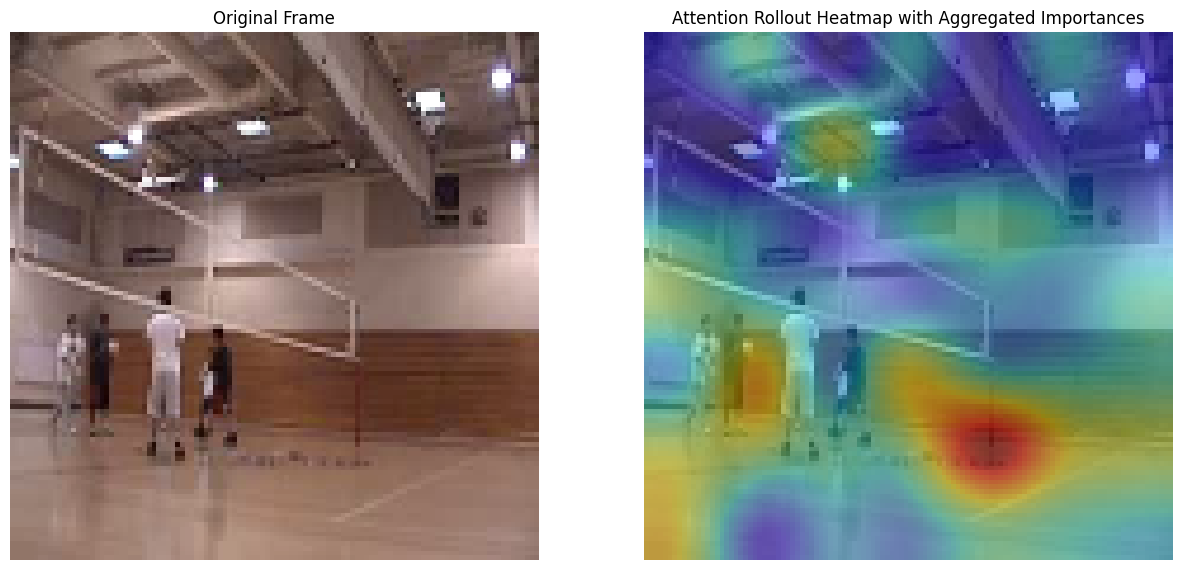

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from einops import rearrange


# mean/std from training normalization
mean = np.array([0.43216, 0.394666, 0.37645])
std = np.array([0.22803, 0.22145, 0.216989])


# batch_size=1 for simplicity
test_loader = torch.utils.data.DataLoader(
    test_loader.dataset,
    batch_size=1,
    shuffle=False,
    num_workers=test_loader.num_workers,
    pin_memory=True
)

batch_videos, batch_labels = next(iter(test_loader))
batch_videos = batch_videos.permute(0, 2, 1, 3, 4).to(device)  # [B, T, C, H, W]
model.eval()

with torch.no_grad():
    outputs, attention_maps = model(batch_videos, return_attention=True)

spatial_attention_list = [layer_maps['spatial_attn'] for layer_maps in attention_maps]

num_layers = len(spatial_attention_list)
num_heads = model.heads

print("Sanity Check: number of layers:", num_layers)
print("Sanity Check: model heads:", num_heads)
for i, att in enumerate(spatial_attention_list):
    print(f"Layer {i}: attention shape:", att.shape)

b_h, q, k = spatial_attention_list[0].shape
effective_batch_size = b_h // num_heads
print(f"Detected effective batch size (clips per video): {effective_batch_size}")

def attention_rollout(attention_list, num_layers, num_heads):
    """
    Compute attention rollout for a single clip's spatial-based attention maps.
    """
    first_att = attention_list[0]
    initial_seq_len = first_att.shape[-1]
    rollout = torch.eye(initial_seq_len, device=first_att.device)
    print("Initial rollout shape:", rollout.shape)
    print("Initial seq_len:", initial_seq_len)

    for layer_idx, att in enumerate(attention_list):
        if att.dim() != 3:
            raise ValueError(f"Attention map at layer {layer_idx} has incorrect dimensions: {att.shape}")

        b_h_layer, q_layer, k_layer = att.shape
        if b_h_layer % num_heads != 0:
            raise ValueError(f"Attention map batch dimension {b_h_layer} is not divisible by num_heads {num_heads}")

        b_layer = b_h_layer // num_heads
        print(f"\n--- Processing layer {layer_idx} ---")
        print("Attention shape:", att.shape)
        print(f"b={b_layer}, num_heads={num_heads}, q={q_layer}, k={k_layer}")

        min_dim = min(q_layer, k_layer)
        # Adjust rollout if needed
        if rollout.shape[0] != min_dim or rollout.shape[1] != min_dim:
            current_min = min(rollout.shape[0], rollout.shape[1], min_dim)
            rollout = rollout[:current_min, :current_min]
            print("Adjusted rollout shape:", rollout.shape)
            min_dim = current_min

        if b_layer < 1:
            raise ValueError("No samples found. Check the batch size and indexing.")

        att_first = att[:num_heads]  # [heads, Q, K]
        print("att_first shape:", att_first.shape)

        # Average over heads to get [Q, K]
        att_avg = att_first.mean(dim=0)
        print("att_avg shape after averaging heads:", att_avg.shape)

        att_avg = att_avg[:min_dim, :min_dim]

        if rollout.shape[0] != min_dim or rollout.shape[1] != min_dim:
            current_min = min(rollout.shape[0], rollout.shape[1], min_dim)
            att_avg = att_avg[:current_min, :current_min]
            rollout = rollout[:current_min, :current_min]
            print("Further adjusted shapes to match min_dim:", current_min)

        print("rollout shape before matmul:", rollout.shape)
        print("att_avg shape:", att_avg.shape)

        rollout = att_avg @ rollout
        sum_over_rows = rollout.sum(dim=-1, keepdim=True)
        zero_rows = (sum_over_rows == 0)
        if zero_rows.any():
            print("Warning: some rows sum to zero, adjusting normalization.")
            sum_over_rows[zero_rows] = 1.0
        rollout = rollout / sum_over_rows

        print("rollout shape after layer:", rollout.shape)

    return rollout

rollout_maps = []

for clip_idx in range(effective_batch_size):
    print(f"\nProcessing clip {clip_idx + 1}/{effective_batch_size}")
    # Extract attention maps for this clip across all layers
    per_clip_attention_list = [
        layer_att[clip_idx * num_heads : (clip_idx + 1) * num_heads, :, :]
        for layer_att in spatial_attention_list
    ]
    # Perform attention rollout for this clip
    per_clip_rollout_map = attention_rollout(per_clip_attention_list, num_layers, num_heads)
    rollout_maps.append(per_clip_rollout_map)

# Aggregate rollout maps  by averaging
final_rollout_map = torch.stack(rollout_maps).mean(dim=0)
print("Sanity Check: final_rollout_map shape after aggregation:", final_rollout_map.shape)

b = 0  # Batch index (since batch_size=1)
_, C, T, H_, W_ = batch_videos.shape
p = model.patch_size
hp = H_ // p
wp = W_ // p
f = T
n = hp * wp

token_importances = final_rollout_map.sum(dim=0).detach().cpu().numpy()  # [49]

print(f"token_importances.size={token_importances.size}, expected={hp * wp}")

if token_importances.size != hp * wp:
    print(f"Mismatch in token_importances.size={token_importances.size}, expected={hp * wp}.")
    # Attempt to find factors of token_importances.size to reshape
    possible_factors = [
        (i, token_importances.size // i)
        for i in range(1, int(np.sqrt(token_importances.size)) + 1)
        if token_importances.size % i == 0
    ]
    print(
        f"Possible (hp, wp) pairs based on token_importances.size={token_importances.size}: {possible_factors}"
    )

    if len(possible_factors) > 0:
        hp, wp = possible_factors[0]  # first pair
        print(f"Adjust hp and wp to: hp={hp}, wp={wp}")
    else:
        raise ValueError("Cannot reshape token_importances into a grid.")

# Reshape token importances to (hp, wp)
try:
    token_importances = token_importances.reshape(hp, wp)
    print("Sanity Check: token_importances shape:", token_importances.shape)
except Exception as e:
    raise ValueError(f"Error reshaping token_importances: {e}")


frame_index = 0

frame_importance = token_importances
frame_importance_resized = cv2.resize(
    frame_importance, (W_, H_), interpolation=cv2.INTER_CUBIC
)
frame_importance_norm = (
    frame_importance_resized - frame_importance_resized.min()
) / (
    frame_importance_resized.max() - frame_importance_resized.min() + 1e-5
)


original_frame = batch_videos[b, frame_index, :3, :, :].detach().cpu().numpy()  # [3, H, W]

for c_ in range(3):
    original_frame[c_] = original_frame[c_] * std[c_] + mean[c_]

original_frame = (original_frame * 255).clip(0, 255).astype(np.uint8)
original_frame = np.transpose(original_frame, (1, 2, 0))  # [H, W, C]

print("Sanity Check: original_frame shape:", original_frame.shape)  # Should be [H, W, 3]
print("heatmap shape before resizing:", frame_importance_norm.shape)  # Should be [H, W]

# Generate heatmap from the normalized importance map
heatmap = (plt.cm.jet(frame_importance_norm)[:, :, :3] * 255).astype(np.uint8)
print(f"heatmap shape after jet colormap: {heatmap.shape}")  # Should be [H, W, 3]

# Ensure both images have the same dimensions and number of channels
if original_frame.shape != heatmap.shape:
    print("Mismatch in original_frame and heatmap shapes. Resizing heatmap to match original_frame.")
    heatmap = cv2.resize(
        heatmap, (original_frame.shape[1], original_frame.shape[0]), interpolation=cv2.INTER_CUBIC
    )
    print(f"heatmap shape after resizing: {heatmap.shape}")

# Overlay the heatmap on the original frame
try:
    overlayed = cv2.addWeighted(original_frame, 0.6, heatmap, 0.4, 0)
except cv2.error as e:
    raise ValueError(f"Error during overlay: {e}")

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_frame)
plt.title("Original Frame")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlayed)
plt.title("Attention Rollout Heatmap with Aggregated Importances")
plt.axis('off')

plt.show()


Top 5 Classes by Accuracy:
PlayingCello: 100.00%
PlayingDaf: 100.00%
PlayingDhol: 100.00%
Drumming: 100.00%
LongJump: 100.00%


Visualizing Correct Predictions of Top-5 Well-Performed Classes


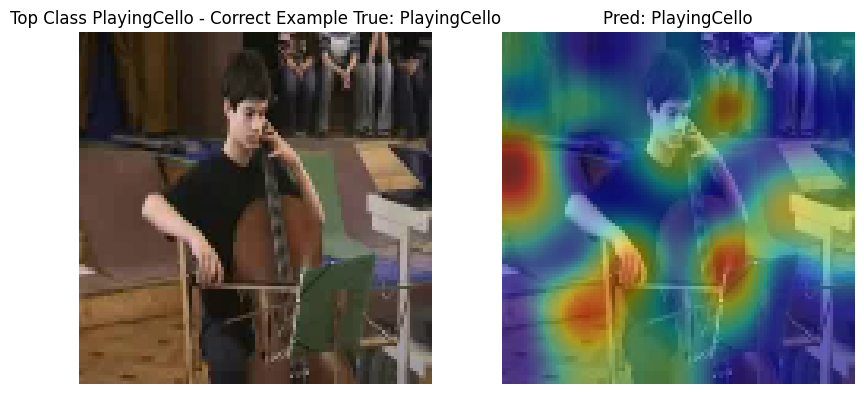

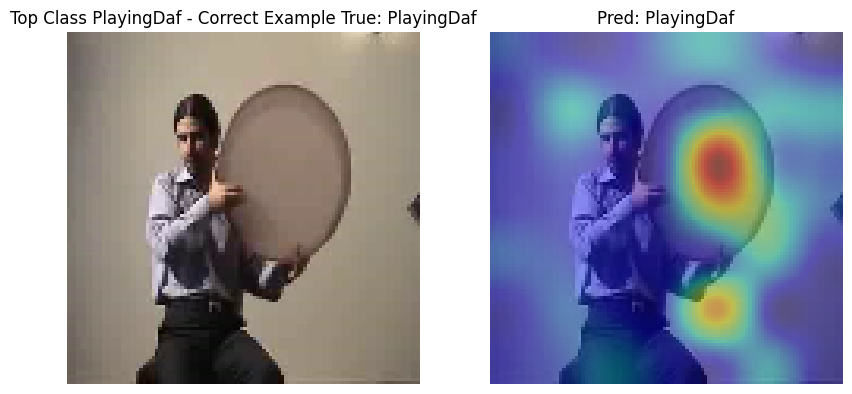

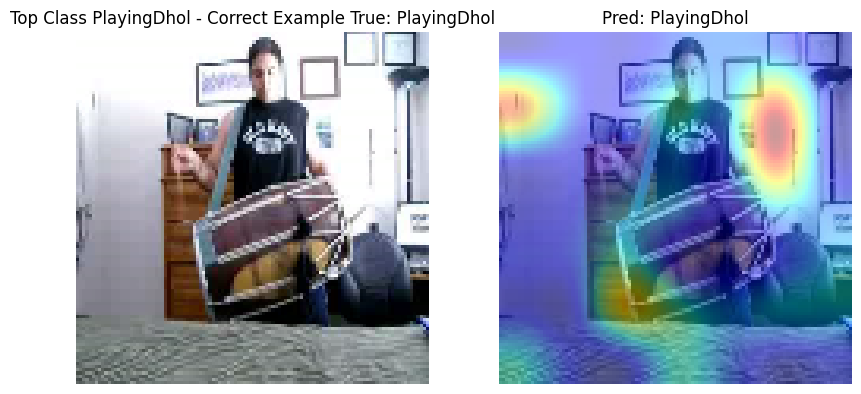

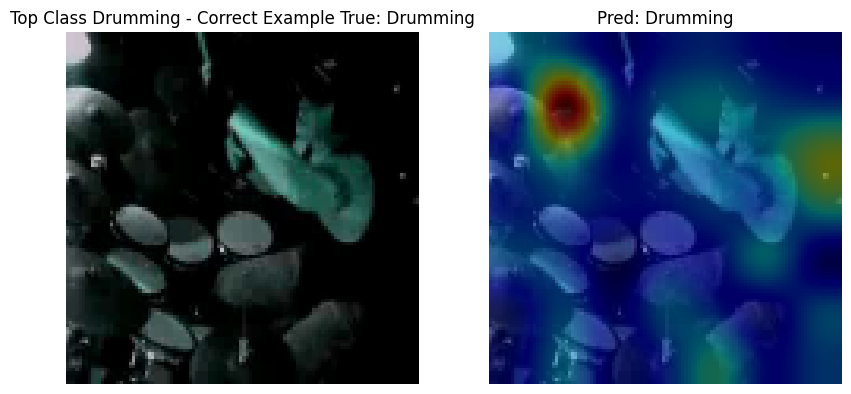

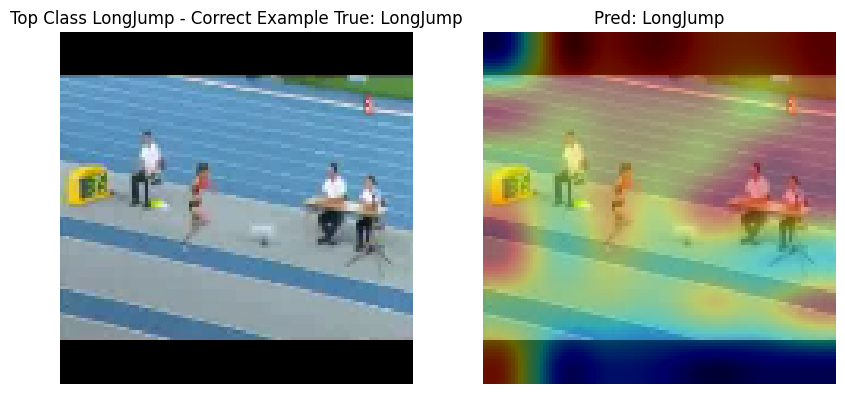



Visualizing Incorrect Predictions of Bottom-5 Poor-Performed Classes


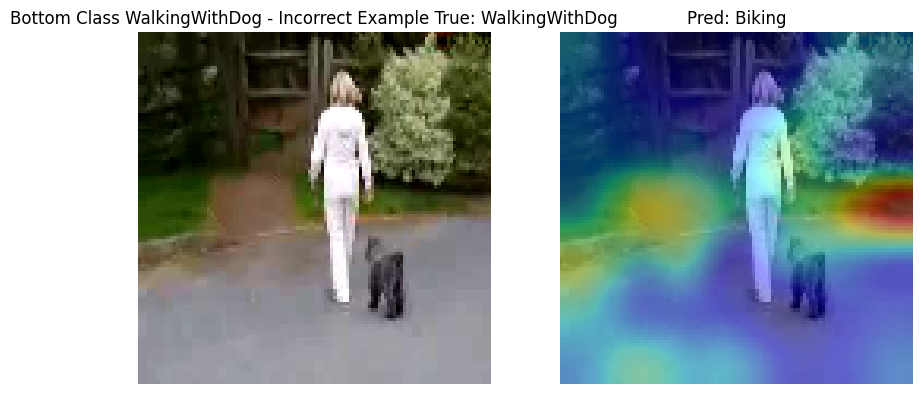

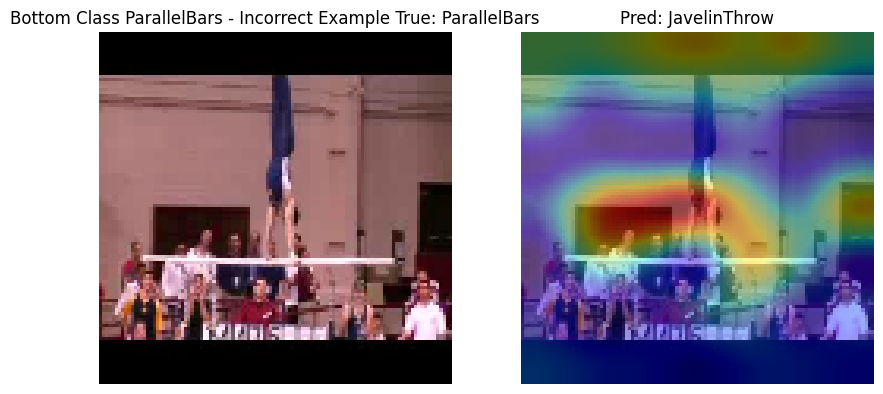

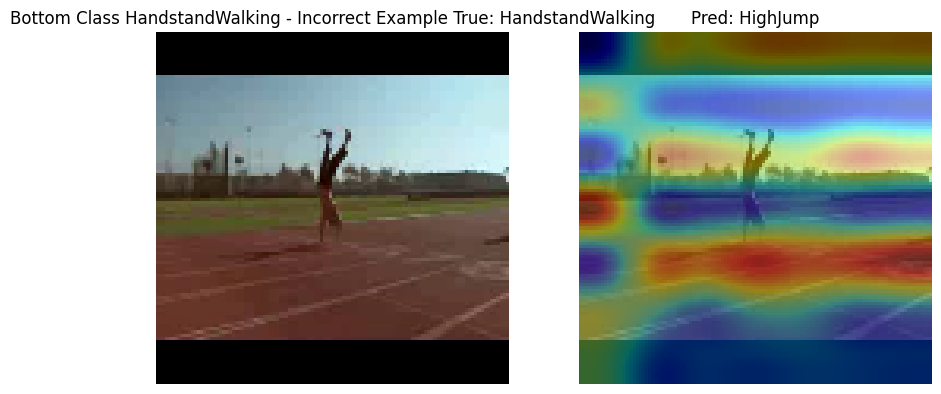

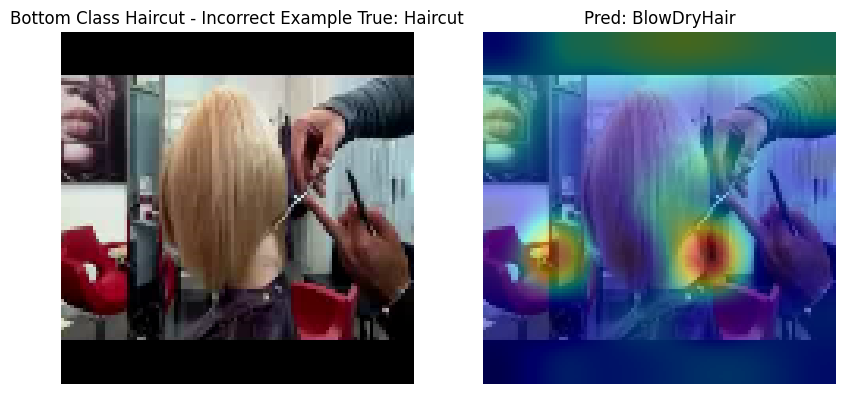

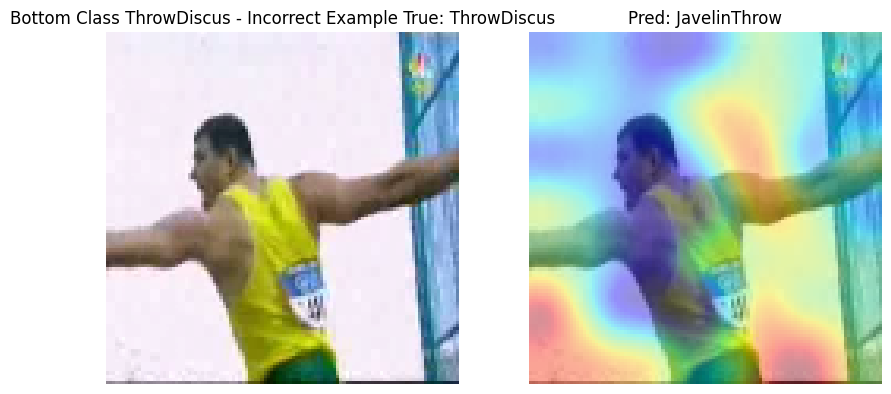

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from einops import rearrange

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = []
all_preds = []
dataset = test_loader.dataset

with torch.no_grad():
    for batch_videos, batch_labels in test_loader:
        # If the batch size > 1, handle all samples in the batch
        batch_videos = batch_videos.permute(0, 2, 1, 3, 4).to(device)
        outputs = model(batch_videos)
        _, predicted = torch.max(outputs, 1)

        for lbl, pred in zip(batch_labels, predicted):
            all_labels.append(lbl.item())
            all_preds.append(pred.item())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

NUM_CLASSES = len(idx_to_class)
class_correct = np.zeros(NUM_CLASSES)
class_total = np.zeros(NUM_CLASSES)

for lbl, pred in zip(all_labels, all_preds):
    class_total[lbl] += 1
    if lbl == pred:
        class_correct[lbl] += 1

class_acc = class_correct / np.maximum(class_total, 1e-10)

valid_classes = [i for i in range(NUM_CLASSES) if class_total[i] > 0]

if len(valid_classes) == 0:
    print("No classes found in the test set. Cannot determine top or bottom classes.")
else:
    valid_class_acc = class_acc[valid_classes]
    valid_class_acc_indices = np.argsort(valid_class_acc)

    top_5_classes = [valid_classes[i] for i in valid_class_acc_indices[-5:]]
    bottom_5_classes = [valid_classes[i] for i in valid_class_acc_indices[:5]]

    print("Top 5 Classes by Accuracy:")
    for c in top_5_classes:
        print(f"{idx_to_class[c]}: {class_acc[c]*100:.2f}%")

    def get_example_for_class(target_class, correct=True):
        indices = np.where(all_labels == target_class)[0]
        if correct:
            # Find a correctly predicted example
            for idx in indices:
                if all_preds[idx] == target_class:
                    return idx
        else:
            # Find an incorrectly predicted example
            for idx in indices:
                if all_preds[idx] != target_class:
                    return idx
        return None

    def attention_rollout(attention_list, num_layers, num_heads):
        first_att = attention_list[0]
        initial_seq_len = first_att.shape[-1]
        rollout = torch.eye(initial_seq_len, device=first_att.device)

        for layer_idx, att in enumerate(attention_list):
            if att.dim() != 3:
                raise ValueError(f"Attention map at layer {layer_idx} has incorrect dimensions: {att.shape}")

            b_h_layer, q_layer, k_layer = att.shape
            if b_h_layer % num_heads != 0:
                raise ValueError(f"Attention map batch dimension {b_h_layer} is not divisible by num_heads {num_heads}")

            heads = num_heads
            att_first = att[:heads]  # [heads, q, k]
            att_avg = att_first.mean(dim=0)  # [q, k]

            min_dim = min(att_avg.shape[0], att_avg.shape[1], rollout.shape[0], rollout.shape[1])
            att_avg = att_avg[:min_dim, :min_dim]
            rollout = rollout[:min_dim, :min_dim]

            # Multiply and normalize
            rollout = att_avg @ rollout
            sum_over_rows = rollout.sum(dim=-1, keepdim=True)
            zero_rows = (sum_over_rows == 0)
            if zero_rows.any():
                sum_over_rows[zero_rows] = 1.0
            rollout = rollout / sum_over_rows

        return rollout

    def visualize_for_example(example_idx, title_prefix=""):
        video, label = dataset[example_idx]
        if torch.is_tensor(label):
            label = label.item()

        video = video.unsqueeze(0)  # [1, C, T, H, W]
        video = video.permute(0, 2, 1, 3, 4).to(device)

        with torch.no_grad():
            outputs, attention_maps = model(video, return_attention=True)

        pred_class = outputs.argmax(dim=1).item()

        spatial_attention_list = [layer_maps['spatial_attn'] for layer_maps in attention_maps]
        num_layers = len(spatial_attention_list)
        num_heads = model.heads

        b_h, q, k = spatial_attention_list[0].shape
        effective_batch_size = b_h // num_heads

        per_clip_attention_list = [
            layer_att[0*num_heads:(0+1)*num_heads, :, :]
            for layer_att in spatial_attention_list
        ]

        final_rollout_map = attention_rollout(per_clip_attention_list, num_layers, num_heads)

        _, C, T, H_, W_ = video.shape
        p = model.patch_size
        hp = H_ // p
        wp = W_ // p

        token_importances = final_rollout_map.sum(dim=0).detach().cpu().numpy()

        if token_importances.size != hp * wp:
            factors = [
                (i, token_importances.size // i)
                for i in range(1, int(np.sqrt(token_importances.size)) + 1)
                if token_importances.size % i == 0
            ]
            if len(factors) > 0:
                hp, wp = factors[0]  # pick the first factor pair
            else:
                print("Cannot factor token_importances into a grid.")
                return

        token_importances = token_importances.reshape(hp, wp)
        frame_importance_resized = cv2.resize(
            token_importances, (W_, H_), interpolation=cv2.INTER_CUBIC
        )
        frame_importance_norm = (
            frame_importance_resized - frame_importance_resized.min()
        ) / (
            frame_importance_resized.max() - frame_importance_resized.min() + 1e-5
        )

        mean = np.array([0.43216, 0.394666, 0.37645])
        std = np.array([0.22803, 0.22145, 0.216989])
        frame_index = 0
        original_frame = video[0, frame_index, :3].detach().cpu().numpy()
        for c_ in range(3):
            original_frame[c_] = original_frame[c_]*std[c_] + mean[c_]
        original_frame = (original_frame*255).clip(0,255).astype(np.uint8)
        original_frame = np.transpose(original_frame, (1,2,0))

        heatmap = (plt.cm.jet(frame_importance_norm)[:, :, :3]*255).astype(np.uint8)
        if heatmap.shape[:2] != original_frame.shape[:2]:
            heatmap = cv2.resize(
                heatmap, (original_frame.shape[1], original_frame.shape[0]), interpolation=cv2.INTER_CUBIC
            )

        overlayed = cv2.addWeighted(original_frame, 0.6, heatmap, 0.4, 0)

        true_class_name = idx_to_class.get(label, f"Unknown({label})")
        pred_class_name = idx_to_class.get(pred_class, f"Unknown({pred_class})")

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(original_frame)
        plt.title(f"{title_prefix}True: {true_class_name}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlayed)
        plt.title(f"Pred: {pred_class_name}")
        plt.axis('off')
        plt.show()

    print("\n\nVisualizing Correct Predictions of Top-5 Well-Performed Classes")
    for c in top_5_classes:
        if class_total[c] == 0:
            print(f"No samples found for class {idx_to_class[c]}, skipping...")
            continue
        ex_idx = get_example_for_class(c, correct=True)
        if ex_idx is None:
            print(f"No correct example found for class {idx_to_class[c]}")
            continue
        visualize_for_example(ex_idx, title_prefix=f"Top Class {idx_to_class[c]} - Correct Example ")

    print("\n\nVisualizing Incorrect Predictions of Bottom-5 Poor-Performed Classes")
    for c in bottom_5_classes:
        if class_total[c] == 0:
            print(f"No samples found for class {idx_to_class[c]}, skipping...")
            continue
        ex_idx = get_example_for_class(c, correct=False)
        if ex_idx is None:
            print(f"No incorrect example found for class {idx_to_class[c]}")
            continue
        visualize_for_example(ex_idx, title_prefix=f"Bottom Class {idx_to_class[c]} - Incorrect Example ")
